In [1]:
#load the variables specific to this dataset 
#on brahma, SNPs have been split by DL CV split 
snp_prefix="/srv/scratch/annashch/gecco/manuscript_loci/splits"
model_prefix="/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/gecco.classification.SummitWithin200bpCenter"
test_set_prefix="/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions"
n_folds=10 
num_tasks=5 
all_snps_basename="AnnotationList.labeled.collapsed.txt"
target_layer_idx=-2
tasks=['DNASEC','DNASEV','SW480','HCT116','COLO205']
outf_name="SNP_effect_predictions.txt"
ref_fasta="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"

In [2]:
#load the dependencies
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import pickle 
from abstention.calibration import PlattScaling, IsotonicRegression
from keras.models import load_model, Model 

from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
from kerasAC.generators import * 
from kerasAC.predict import get_model_layer_functor, get_layer_outputs


Using TensorFlow backend.


## Get Ref/Alt predictions and pre-activations 

In [3]:
def load_keras_model(fold,model_prefix,target_layer_idx):    
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}
    model=load_model(".".join([model_prefix,str(fold)]),custom_objects=custom_objects)
    print("loaded model")
    #load the model to predict preacts 
    preact_model=Model(inputs=model.input,
                       outputs=model.layers[target_layer_idx].output)
    print("loaded preact model")
    return model,preact_model

In [4]:
def get_test_set_logits_and_labels(fold,test_set_prefix):
    test_set_pickle_name='.'.join([test_set_prefix,str(fold)])
    test_set_pickle=pickle.load(open(test_set_pickle_name,'rb'))
    test_set_labels=test_set_pickle[1]
    test_set_logits=test_set_pickle[2] 
    return test_set_labels, test_set_logits 

    

In [5]:
def get_calibration_function_classification(logits,labels):
    #need to generate separate calibration function for each task 
    num_tasks=logits.shape[1] 
    calibration_funcs=[] 
    for task_index in range(num_tasks):
        calibration_funcs.append(PlattScaling()(
            valid_preacts=logits[:,task_index],
            valid_labels=labels.iloc[:,task_index].astype(bool)))
    return calibration_funcs

In [6]:
def get_calibration_function_regression(preacts,labels):
    #need to generate separate calibration function for each task 
    num_tasks=preacts.shape[1]
    calibration_funcs=[] 
    for task_index in range(num_tasks):
        calibration_funcs.append(IsotonicRegression()(
            valid_preacts=preacts[:,task_index],
            valid_labels=labels.iloc[:,task_index]))
    return calibration_funcs

In [7]:
def get_snp_generators(fold,snp_prefix,all_snps_basename,ref_fasta):
    snp_file='/'.join([snp_prefix,all_snps_basename+"."+str(fold)])
    snps=pd.read_csv(snp_file,header=0,sep='\t')
    if snps.shape[0]==0: 
        return None,None
    snp_ref_generator=SNPGenerator(snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="Ref")
    snp_alt_generator=SNPGenerator(snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="Alt")
    return snps, snp_ref_generator,snp_alt_generator

In [8]:
def get_calibrated_predictions(logits,calibration_functions): 
    num_tasks=logits.shape[1] 
    num_calibration_functions=len(calibration_functions)
    assert num_tasks == num_calibration_functions 
    calibrated_predictions=None 
    for i in range(num_tasks): 
        task_calibrated_predictions=np.expand_dims(calibration_functions[i](logits[:,i]),axis=1)
        if calibrated_predictions is None: 
            calibrated_predictions=task_calibrated_predictions
        else: 
            calibrated_predictions=np.concatenate((calibrated_predictions,task_calibrated_predictions),axis=1)
    print(calibrated_predictions.shape)
    return calibrated_predictions 

In [29]:
#Create the output file 
outf=open(outf_name,'w')
#Write the header 
outf.write("\t".join(['Chrom','StartPos','EndPos','Ref','Alt','Rsid']))
outf.write('\t'+'\t'.join(['Label.'+task for task in tasks]))
for field in ['RefLogit','RefCalibrated','AltLogit','AltCalibrated']: 
    for task in tasks: 
        outf.write('\t'+field+'.'+task)
outf.write('\n')

1

In [30]:
for fold in range(n_folds): 
    print(fold)
    try:
        snps, snp_ref_generator,snp_alt_generator=get_snp_generators(fold,snp_prefix,all_snps_basename,ref_fasta)
        print("Got snp ref and alt generators")
    except:
        print("fold:"+str(fold)+" appears to be empty, skipping")
        continue 
    model,preact_model = load_keras_model(fold,model_prefix,target_layer_idx)
#    test_set_labels, test_set_logits = get_test_set_logits_and_labels(fold,test_set_prefix)
#    print("loaded test set labels and test set logits ")

#    calibration_functions=get_calibration_function_classification(test_set_logits,
#                                                             test_set_labels)
#    print("Got calibration function for Platt Scaling")
    ref_preacts=preact_model.predict_generator(snp_ref_generator,
                max_queue_size=5000, 
                workers=40, 
                use_multiprocessing=True, 
                verbose=1)
    print("Got ref preacts")
    alt_preacts=preact_model.predict_generator(snp_alt_generator,
                max_queue_size=5000, 
                workers=40, 
                use_multiprocessing=True, 
                verbose=1)    
    print("Got alt preacts")
    snps, snp_ref_generator,snp_alt_generator=get_snp_generators(fold,snp_prefix,all_snps_basename,ref_fasta)
    ref_calibrated_predictions=model.predict_generator(snp_ref_generator,
                max_queue_size=5000, 
                workers=40, 
                use_multiprocessing=True, 
                verbose=1)
    print("Got ref predictions")
    alt_calibrated_predictions=model.predict_generator(snp_alt_generator,
                max_queue_size=5000, 
                workers=40, 
                use_multiprocessing=True, 
                verbose=1)    
    print("Got alt predictions")
    
    
    
    #ref_calibrated_predictions=get_calibrated_predictions(ref_preacts,
    #                                                      calibration_functions)
    #print("Got calibrated reference predictions")
    #alt_calibrated_predictions=get_calibrated_predictions(alt_preacts,
    #                                                      calibration_functions)
    #print("Got calibrated alternate predictions")
    
    num_snps=ref_calibrated_predictions.shape[0]
    for snp_index in range(num_snps): 
        outf.write('\t'.join([str(j) for j in snps.iloc[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in ref_preacts[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in ref_calibrated_predictions[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in alt_preacts[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in alt_calibrated_predictions[snp_index]])+
                   '\n')
outf.close() 

0
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
Got snp ref and alt generators


/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 8s 8s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.0
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
1/1 [==============================] - 8s 8s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions
1
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.1
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(1, 8)
(1, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.1
tasks:No

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 8s 8s/step
Got ref preacts
1/1 [==============================] - 4s 4s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.1
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(1, 8)
(1, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.1
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(1, 8)
(1, 8)
1/1 [==============================] - 9s 9s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions
2
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.2
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.2
tasks:No

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 9s 9s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.2
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.2
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(7, 8)
(7, 8)
1/1 [==============================] - 9s 9s/step
Got ref predictions
1/1 [==============================] - 4s 4s/step
Got alt predictions
3
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.3
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(31, 8)
(31, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.3
tasks:

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 9s 9s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.3
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(31, 8)
(31, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.3
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(31, 8)
(31, 8)
1/1 [==============================] - 9s 9s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions
4
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.4
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(21, 8)
(21, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.4
ta

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 9s 9s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.4
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(21, 8)
(21, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.4
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(21, 8)
(21, 8)
1/1 [==============================] - 9s 9s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions
5
fold:5 appears to be empty, skipping
6
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.6
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(62, 8)
(62, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/An

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 10s 10s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.6
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(62, 8)
(62, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.6
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(62, 8)
(62, 8)
1/1 [==============================] - 10s 10s/step
Got ref predictions
1/1 [==============================] - 4s 4s/step
Got alt predictions
7
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.7
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(20, 8)
(20, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 10s 10s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.7
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(20, 8)
(20, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.7
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(20, 8)
(20, 8)
1/1 [==============================] - 10s 10s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions
8
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.8
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(72, 8)
(72, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 11s 11s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.8
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(72, 8)
(72, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.8
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(72, 8)
(72, 8)
1/1 [==============================] - 12s 12s/step
Got ref predictions
1/1 [==============================] - 4s 4s/step
Got alt predictions
9
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.9
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(53, 8)
(53, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.

/users/annashch/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


loaded model
loaded preact model
1/1 [==============================] - 11s 11s/step
Got ref preacts
1/1 [==============================] - 3s 3s/step
Got alt preacts
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.9
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(53, 8)
(53, 8)
data_path:/srv/scratch/annashch/gecco/manuscript_loci/splits/AnnotationList.labeled.collapsed.txt.9
tasks:None
chroms_to_use:None
loaded labels
filtered on chroms_to_use
data.shape:(53, 8)
(53, 8)
1/1 [==============================] - 11s 11s/step
Got ref predictions
1/1 [==============================] - 3s 3s/step
Got alt predictions


## ISM Plots 

In [31]:
import pandas as pd 
snp_predictions=pd.read_csv(outf_name,header=0,sep='\t')
snp_predictions['Label.DNASEC']=snp_predictions['Label.DNASEC'].astype('category')
snp_predictions['Label.DNASEV']=snp_predictions['Label.DNASEV'].astype('category')
snp_predictions['Label.SW480']=snp_predictions['Label.SW480'].astype('category')
snp_predictions['Label.HCT116']=snp_predictions['Label.HCT116'].astype('category')
snp_predictions['Label.COLO205']=snp_predictions['Label.COLO205'].astype('category')


In [32]:
snp_predictions

,Chrom,StartPos,EndPos,Ref,Alt,Rsid,Label.DNASEC,Label.DNASEV,Label.SW480,Label.HCT116,...,AltLogit.DNASEC,AltLogit.DNASEV,AltLogit.SW480,AltLogit.HCT116,AltLogit.COLO205,AltCalibrated.DNASEC,AltCalibrated.DNASEV,AltCalibrated.SW480,AltCalibrated.HCT116,AltCalibrated.COLO205
0,chr1,111740344,111740345,C,G,rs599134,0.0,0.0,0.0,0.0,...,-3.613002,-0.987142,-1.193470,-2.724306,-2.484255,0.026262,2.714770e-01,0.232639,0.061554,7.696939e-02
1,chr1,167028803,167028804,T,C,rs12123175,0.0,1.0,0.0,1.0,...,-1.742210,1.374034,-0.781482,-0.620937,-1.468845,0.149032,7.980312e-01,0.314001,0.349568,1.871183e-01
2,chr1,172866403,172866404,G,T,rs12747422,0.0,0.0,0.0,0.0,...,-9.132653,-8.527050,-6.613410,-7.329981,-9.985646,0.000108,1.979991e-04,0.001340,0.000655,4.605417e-05
3,chr1,205240912,205240913,T,C,rs9659978,0.0,0.0,0.0,1.0,...,-3.399576,-1.773760,-4.138111,-5.155338,-4.273469,0.032309,1.450754e-01,0.015702,0.005735,1.374189e-02
4,chr1,205241658,205241659,A,G,rs17728,0.0,0.0,0.0,0.0,...,-3.351897,-1.923232,-3.330386,-4.686790,-3.702614,0.033833,1.275016e-01,0.034543,0.009132,2.406555e-02
5,chr1,205248031,205248032,A,G,rs1172134,0.0,0.0,0.0,0.0,...,-7.356604,-4.689422,-5.273683,-5.734062,-5.491638,0.000638,9.108277e-03,0.005099,0.003223,4.104174e-03
6,chr1,205249689,205249690,A,G,rs9661015,1.0,0.0,0.0,0.0,...,-1.859767,-1.801156,-2.483942,-3.261941,-3.345475,0.134730,1.417105e-01,0.076992,0.036900,3.404367e-02
7,chr19,55897326,55897327,A,G,rs17700376,1.0,1.0,1.0,1.0,...,1.409486,2.836126,1.199572,0.690439,0.317021,0.803685,9.445971e-01,0.768449,0.666065,5.785981e-01
8,chr3,52255391,52255392,G,A,rs445676,0.0,0.0,0.0,0.0,...,-6.202770,-4.450554,-4.856573,-6.713372,-5.318675,0.002020,1.153743e-02,0.007717,0.001213,4.875355e-03
9,chr3,52265214,52265215,G,A,rs164637,0.0,0.0,0.0,0.0,...,-3.733554,-1.179392,-1.005449,-5.136994,-3.624231,0.023349,2.351616e-01,0.267872,0.005841,2.597681e-02


In [33]:
import plotnine
from plotnine import * 

### DNAse C 

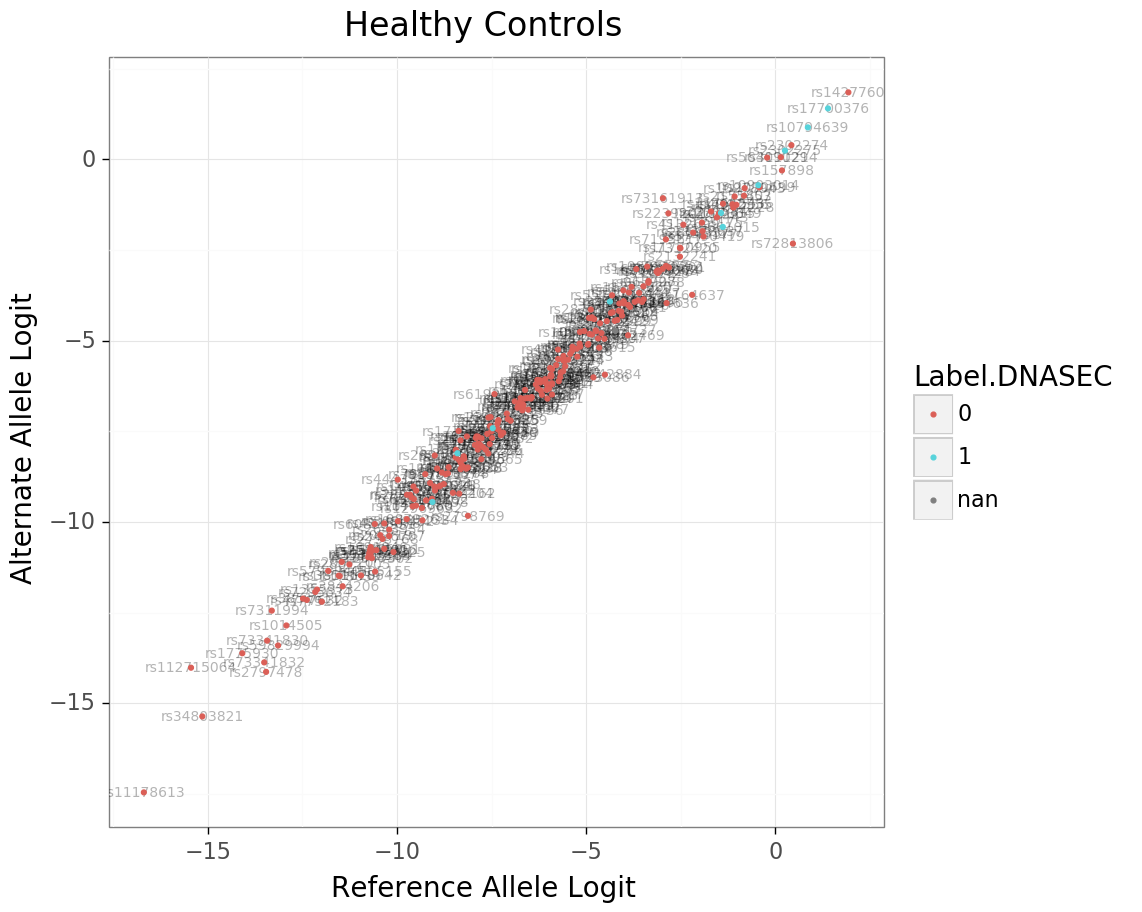

<ggplot: (8791280144199)>

In [80]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefLogit.DNASEC",y="AltLogit.DNASEC",label='Rsid',color='Label.DNASEC',fill='Label.DNASEC'))+
        geom_text(aes(x="RefLogit.DNASEC",y="AltLogit.DNASEC",label='Rsid'),
          inherit_aes=False,
          alpha=0.3,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("Healthy Controls"))


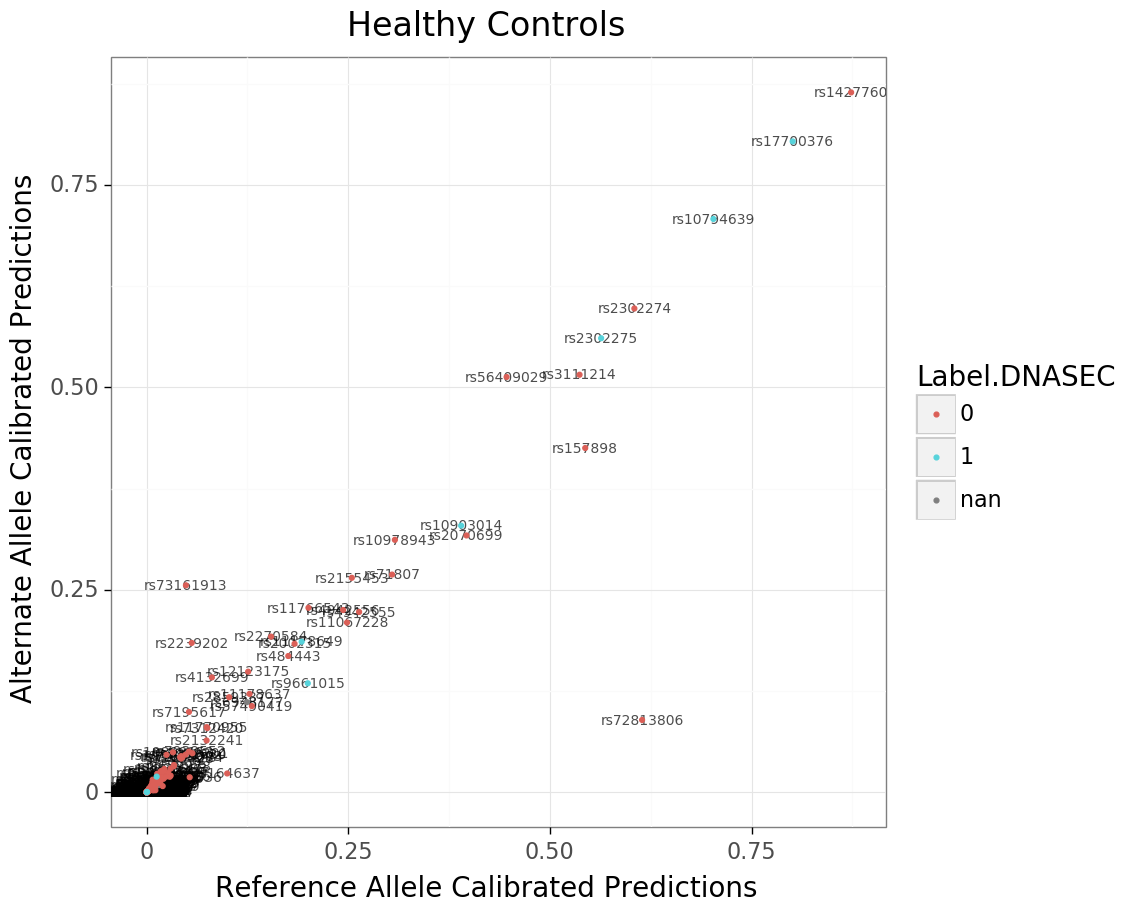

<ggplot: (8791280000467)>

In [82]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefCalibrated.DNASEC",y="AltCalibrated.DNASEC",label='Rsid',color='Label.DNASEC',fill='Label.DNASEC'))+
        geom_text(aes(x="RefCalibrated.DNASEC",y="AltCalibrated.DNASEC",label='Rsid'),
          inherit_aes=False,
          alpha=0.7,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Calibrated Predictions")+
ylab("Alternate Allele Calibrated Predictions")+
ggtitle("Healthy Controls"))


## DNAse V 

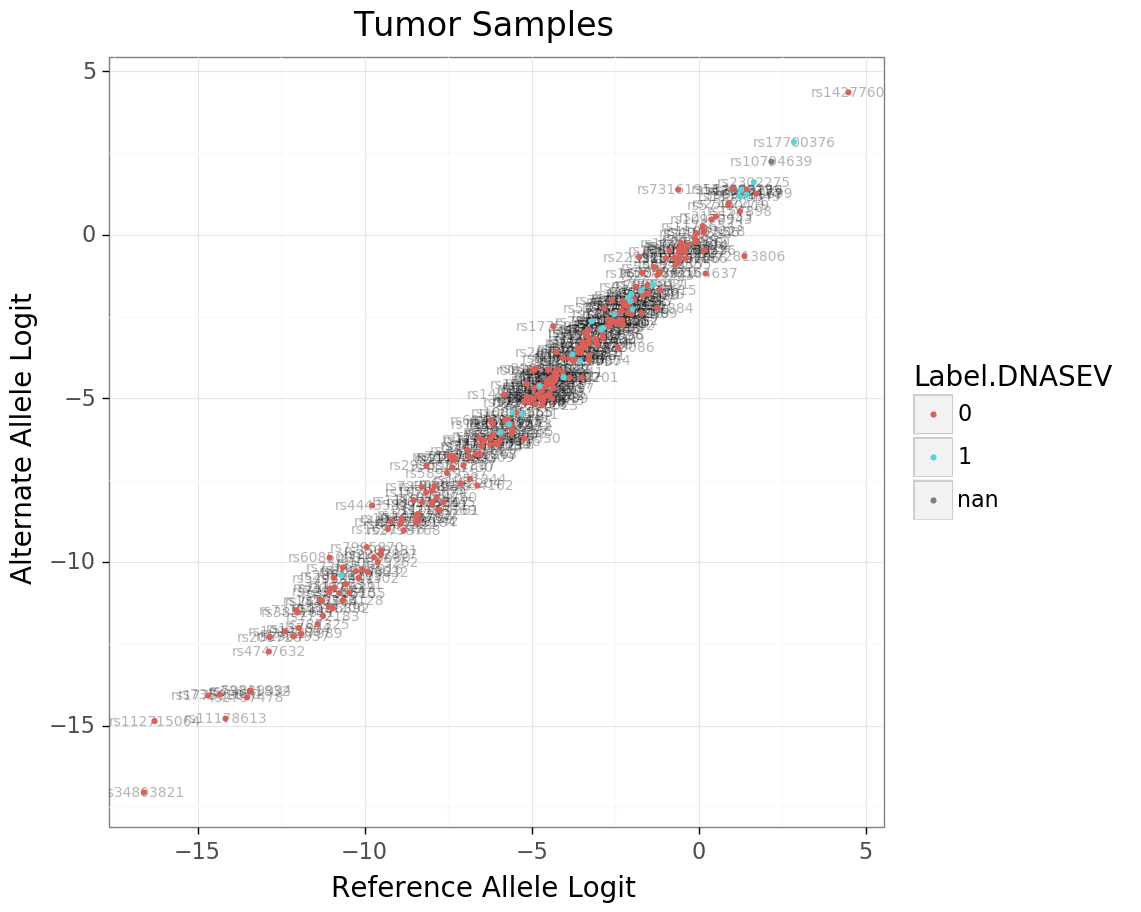

<ggplot: (8791279743699)>

In [84]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefLogit.DNASEV",y="AltLogit.DNASEV",label='Rsid',color='Label.DNASEV',fill='Label.DNASEV'))+
        geom_text(aes(x="RefLogit.DNASEV",y="AltLogit.DNASEV",label='Rsid'),
          inherit_aes=False,
          alpha=0.3,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("Tumor Samples"))


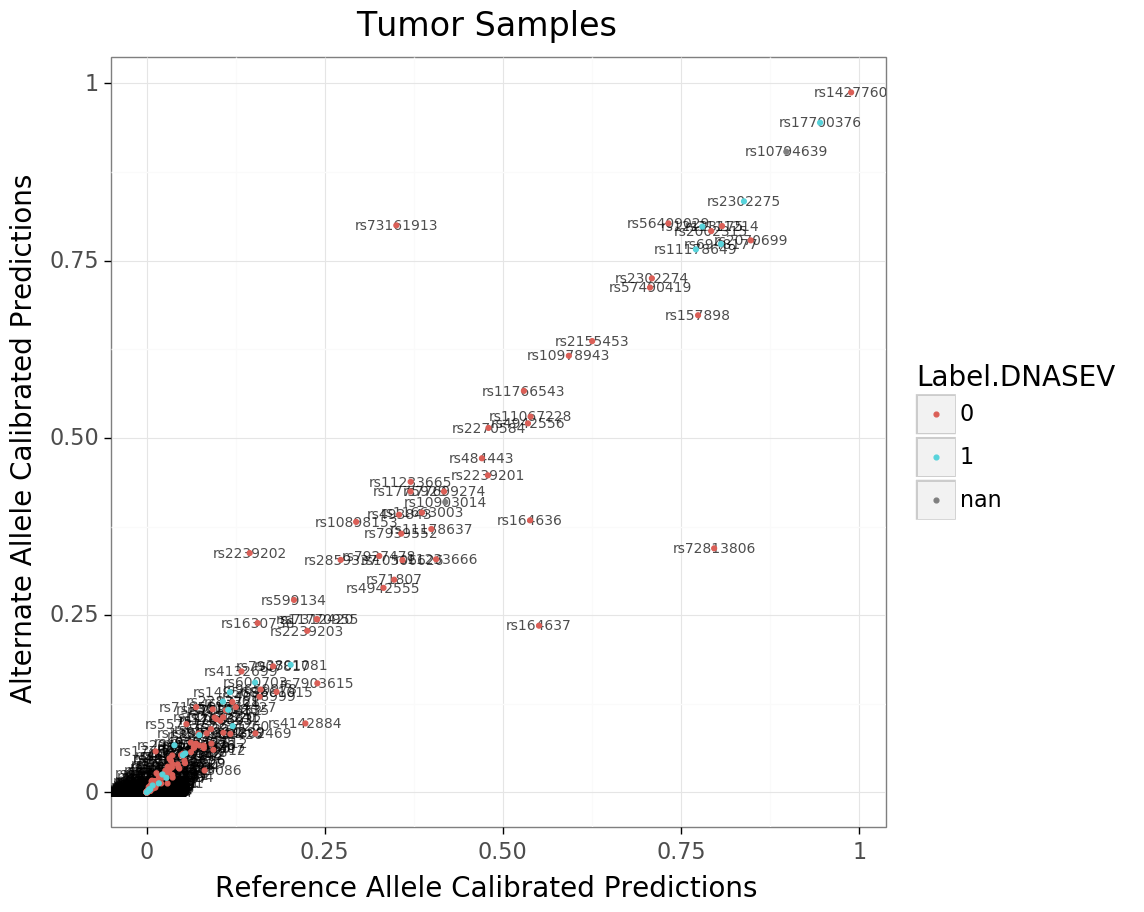

<ggplot: (-9223363245575308165)>

In [85]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefCalibrated.DNASEV",y="AltCalibrated.DNASEV",label='Rsid',color='Label.DNASEV',fill='Label.DNASEV'))+
        geom_text(aes(x="RefCalibrated.DNASEV",y="AltCalibrated.DNASEV",label='Rsid'),
          inherit_aes=False,
          alpha=0.7,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Calibrated Predictions")+
ylab("Alternate Allele Calibrated Predictions")+
ggtitle("Tumor Samples"))


## SW480

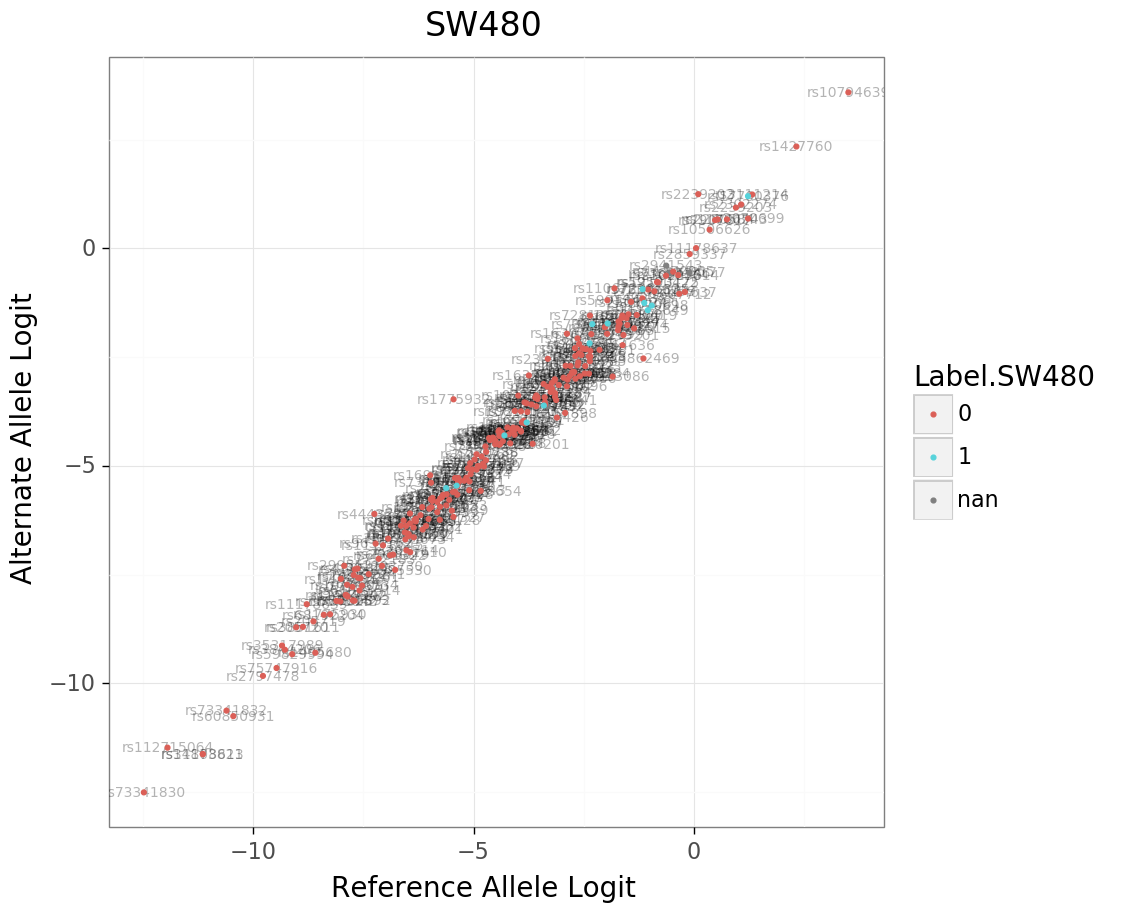

<ggplot: (8791279445715)>

In [86]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefLogit.SW480",y="AltLogit.SW480",label='Rsid',color='Label.SW480',fill='Label.SW480'))+
        geom_text(aes(x="RefLogit.SW480",y="AltLogit.SW480",label='Rsid'),
          inherit_aes=False,
          alpha=0.3,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("SW480"))

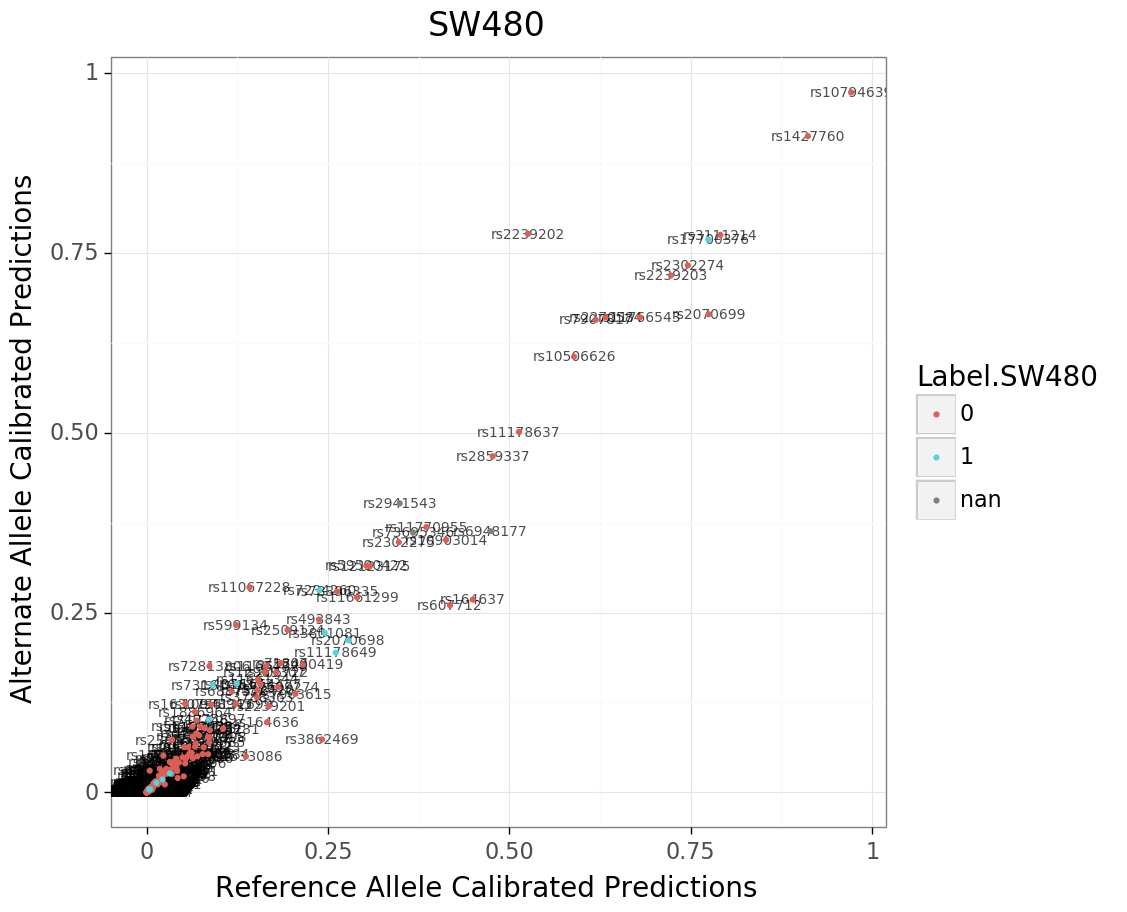

<ggplot: (-9223363245575573830)>

In [87]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefCalibrated.SW480",y="AltCalibrated.SW480",label='Rsid',color='Label.SW480',fill='Label.SW480'))+
        geom_text(aes(x="RefCalibrated.SW480",y="AltCalibrated.SW480",label='Rsid'),
          inherit_aes=False,
          alpha=0.7,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Calibrated Predictions")+
ylab("Alternate Allele Calibrated Predictions")+
ggtitle("SW480"))


## HCT116

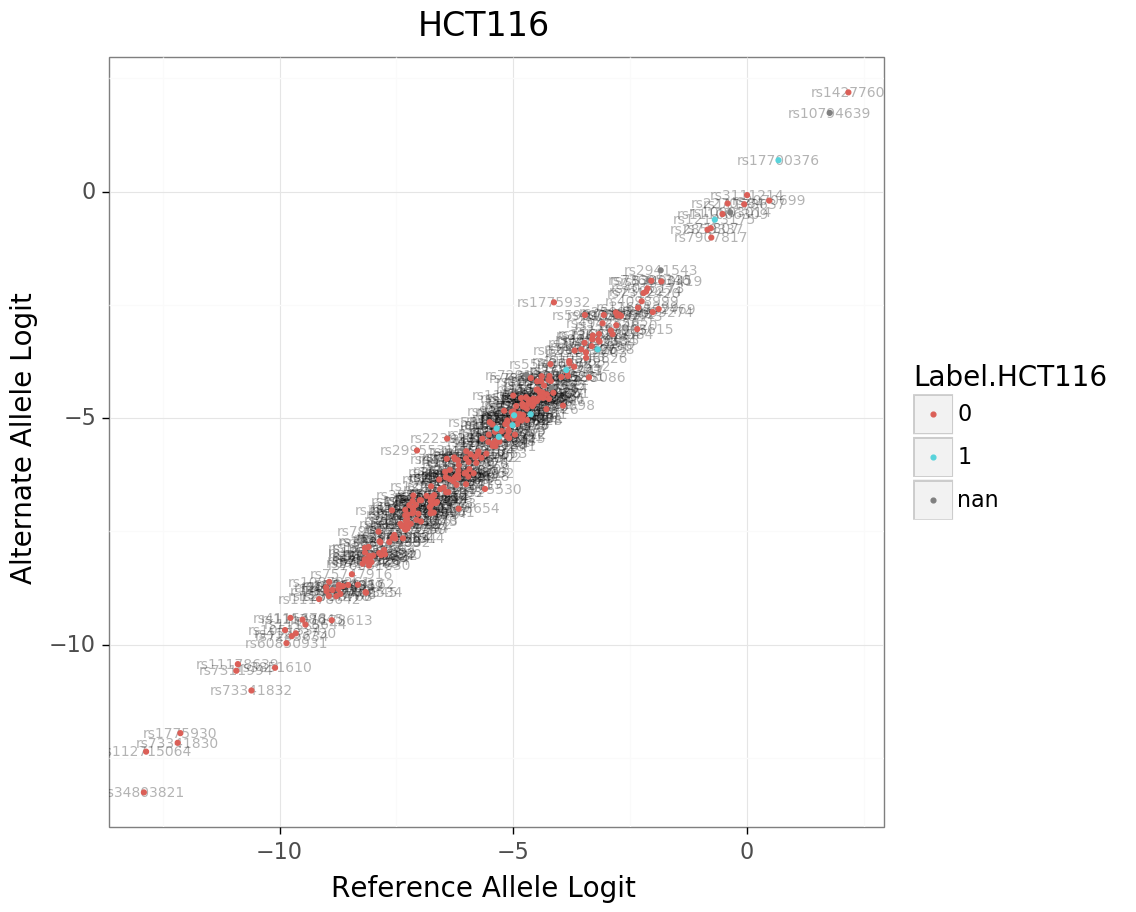

<ggplot: (8791279204023)>

In [88]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefLogit.HCT116",y="AltLogit.HCT116",label='Rsid',color='Label.HCT116',fill='Label.HCT116'))+
        geom_text(aes(x="RefLogit.HCT116",y="AltLogit.HCT116",label='Rsid'),
          inherit_aes=False,
          alpha=0.3,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("HCT116"))

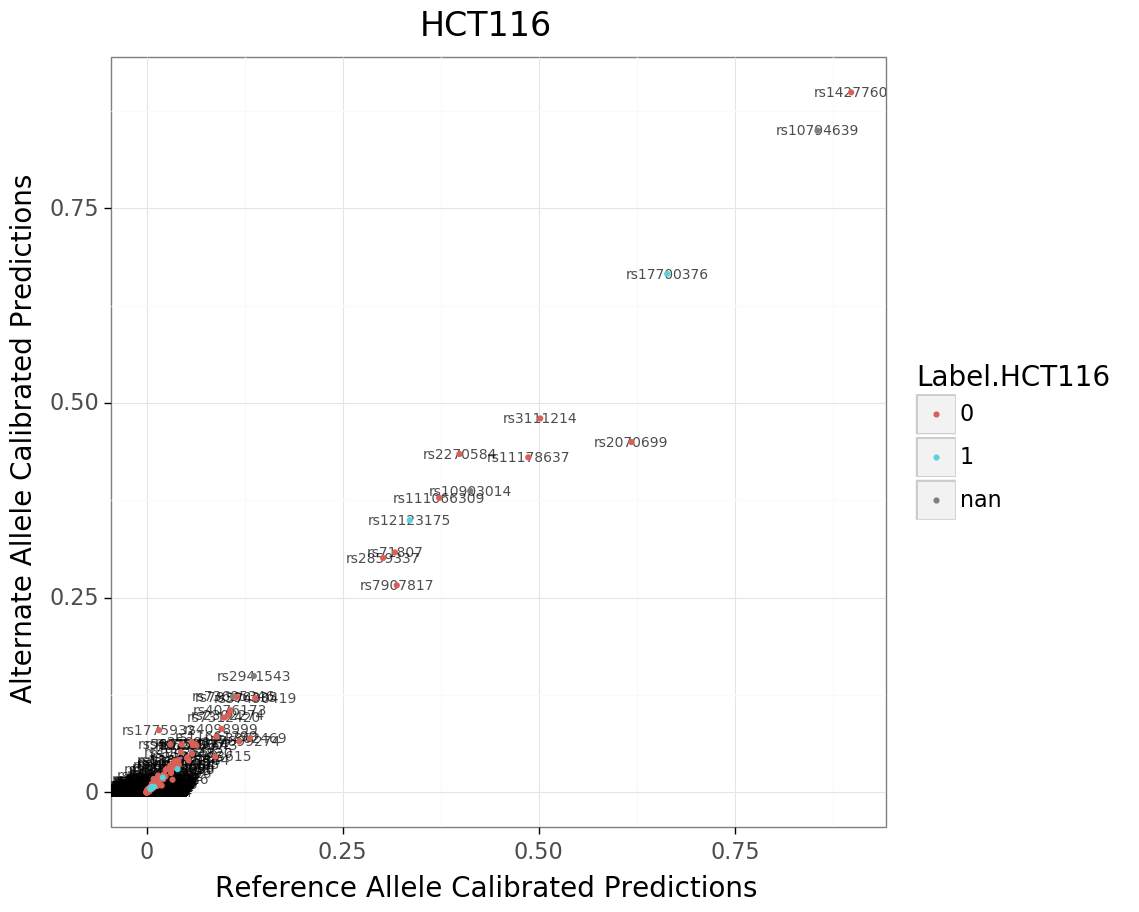

<ggplot: (-9223363245575835055)>

In [89]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefCalibrated.HCT116",y="AltCalibrated.HCT116",label='Rsid',color='Label.HCT116',fill='Label.HCT116'))+
        geom_text(aes(x="RefCalibrated.HCT116",y="AltCalibrated.HCT116",label='Rsid'),
          inherit_aes=False,
          alpha=0.7,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Calibrated Predictions")+
ylab("Alternate Allele Calibrated Predictions")+
ggtitle("HCT116"))


## COLO205

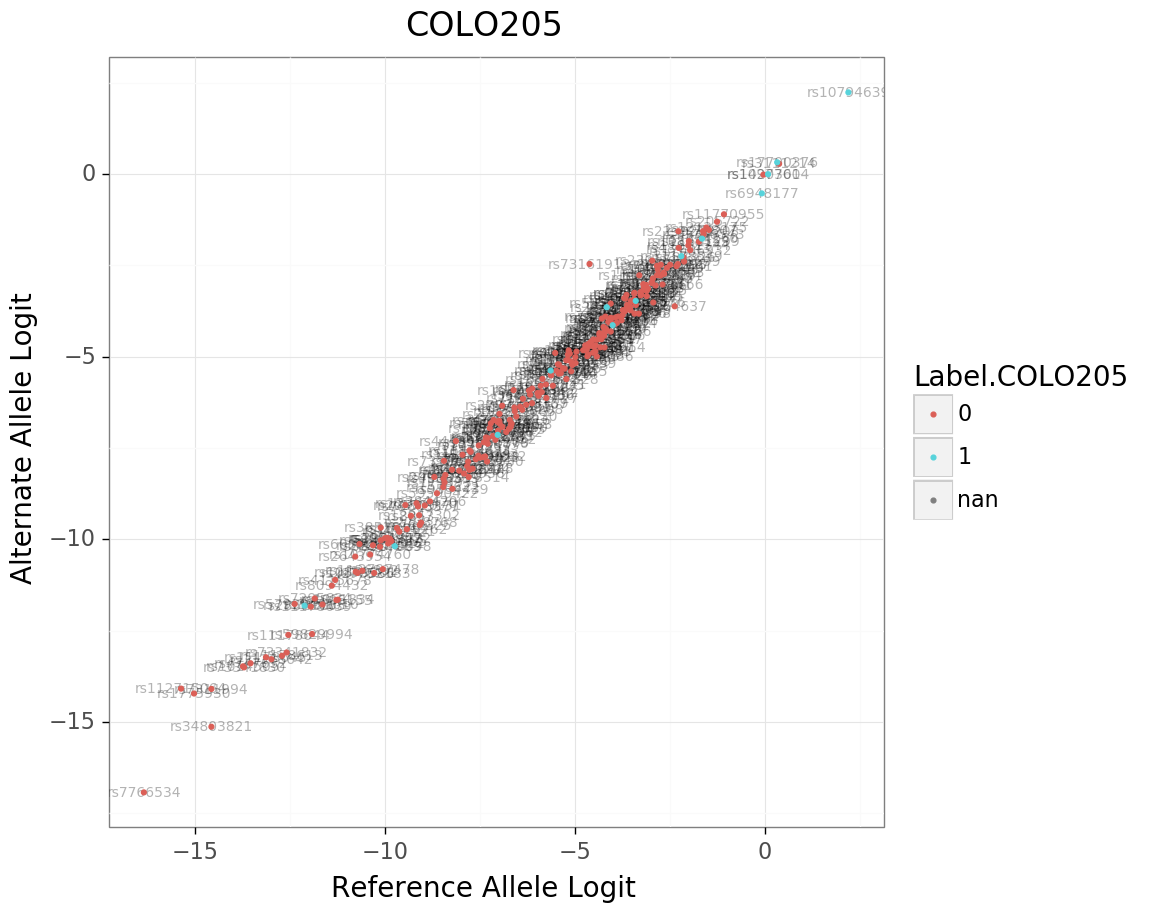

<ggplot: (-9223363245575729422)>

In [90]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefLogit.COLO205",y="AltLogit.COLO205",label='Rsid',color='Label.COLO205',fill='Label.COLO205'))+
        geom_text(aes(x="RefLogit.COLO205",y="AltLogit.COLO205",label='Rsid'),
          inherit_aes=False,
          alpha=0.3,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("COLO205"))


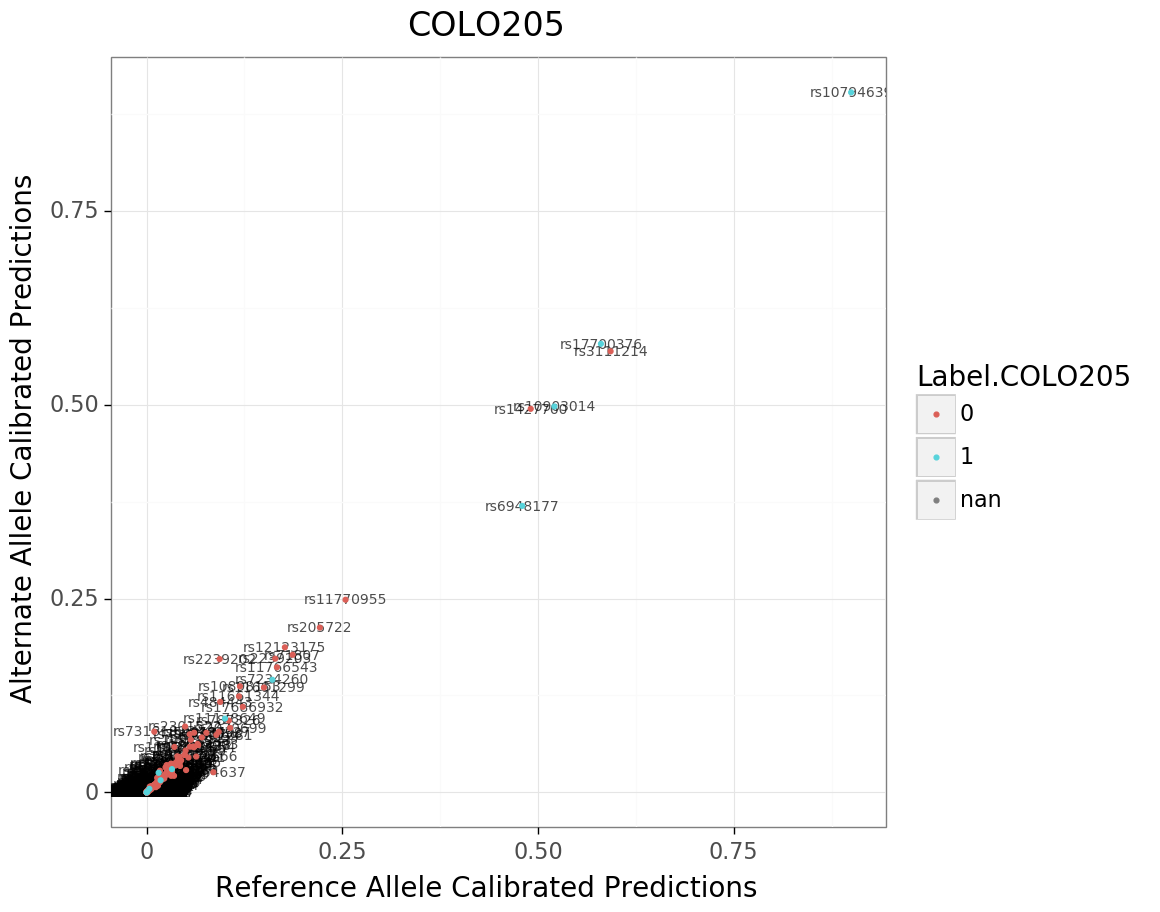

<ggplot: (8791278663814)>

In [91]:
plotnine.options.figure_size = (10,10)
(ggplot(snp_predictions,
        aes(x="RefCalibrated.COLO205",y="AltCalibrated.COLO205",label='Rsid',color='Label.COLO205',fill='Label.COLO205'))+
        geom_text(aes(x="RefCalibrated.COLO205",y="AltCalibrated.COLO205",label='Rsid'),
          inherit_aes=False,
          alpha=0.7,
          size=10)+
geom_point(alpha=1)+
theme_bw(20)+
xlab("Reference Allele Calibrated Predictions")+
ylab("Alternate Allele Calibrated Predictions")+
ggtitle("COLO205"))
